# C4021 - Group 4.2 
## Project work Weeks 7-9
### Participants

| Student Name   |   Id    |
|----------|:-------------:|
| Michel DANJOU |  18263461 |
| Brian PARLE | |
| Gerry KERLEY | |
| Gana SUBRAMANIAN | |


## Machine Learning Algorithm: Baysian Classifier
Source: http://scikit-learn.org/stable/modules/naive_bayes.html


## Dataset Information
### Iris dataset
http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

### Nasa dataset

_Source:_ https://www.kaggle.com/shrutimehta/nasa-asteroids-classification (source: Shruti Mehta)

**Content**
The data is about Asteroids - NeoWs. NeoWs (Near Earth Object Web Service) is a RESTful web service for near earth Asteroid information. With NeoWs a user can: search for Asteroids based on their closest approach date to Earth, lookup a specific Asteroid with its NASA JPL small body id, as well as browse the overall data-set.

**Acknowledgements**
Data-set: All the data is from the (http://neo.jpl.nasa.gov/). This API is maintained by SpaceRocks Team: David Greenfield, Arezu Sarvestani, Jason English and Peter Baunach.

**Inspiration**
Finding potential hazardous and non-hazardous asteroids
Features responsible for claiming an asteroid to be hazardous

## Notebook Structure
1. Source Code
1. Iris dataset
    1. Data Loading and Pre-processing
    1. Model training and testing
    1. Model graphing
    1. Model analysis: further eaxamination of significant features etc.
1. Nasa dataset 
    1. Data Loading and Pre-processing
    1. Model training and testing
    1. Model graphing
    1. Model analysis: further eaxamination of significant features etc.


## Team Contributions:
**Training data**
  * Iris dataset: Michel Danjou
  * Nasa dataset: reused Brian Parle's code

**Pre-processing**
  * Iris dataset: Michel Danjou
  * Nasa dataset: reused Brian Parle's code

**Algorithm training and evaluation**
  * Michel Danjou

**Visualisation of outputs**
  * Michel Danjou


# Source code

In [42]:
%reset
%matplotlib inline
%config IPCompleter.greedy=True

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from pandas import DataFrame

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class Log:
    DEBUG = 1
    INFO = 2
    ERROR = 3
    
    
class Dataset:
    """
    The purpose of this class is as follows:
        1) Provide an abstraction layer on top of the data loading APIs
        2) Store the data into a structure that will be consumed by the
            Analysis team
    """
    log_level = Log.INFO

    def __init__(self, name):
        self.name = name
        self.data_loaded = False
        self.training_vs_testing_ratio = 0.7
    

    def __log__(self, message, level=Log.INFO):
        """
        Log a message only if its log level is equal or superior to
        self.log_level
        """
        if level >= self.log_level:
            print(message)
            
            
    def load_data(self):
        """
        Load the dataset
        """
        self.__log__("="*80 + "\nLoading: " + self.name, Log.INFO)
        if self.name is "iris":
            """
            iris.data         : The dataset representing a table of flower
                                measurements. 4 measurements, 150 rows.
            iris.feature_names: ['sepal length (cm)', 'sepal width (cm)',
                                 'petal length (cm)', 'petal width (cm)']
            iris.target       : Dataset targets (aka labels)
            iris.target_names : ['setosa' 'versicolor' 'virginica']
                                human readable names corresponding to the
                                labels.
            """
            iris = datasets.load_iris()
            self.data = iris.data
            self.target = iris.target
            self.feature_names = iris.feature_names
            self.target_names = iris.target_names
            self.data_loaded = True

            self.__log__("self.target.shape:{}".format(self.target.shape), Log.DEBUG)            

        elif self.name is "nasa":
            """
            See the Random Forrest notebook from Brian Parle for details
            regarding the cleaning up of the nasa dataset 
            """
            df = pd.read_csv('nasa.csv')
            df = df.drop(['Est Dia in KM(min)', 'Est Dia in KM(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)'], axis=1)
            df = df.drop(['Close Approach Date'], axis=1)
            df = df.drop(['Orbiting Body'], axis=1)
            df = df.drop(['Orbit Determination Date'], axis=1)
            df = df.drop(['Equinox'], axis=1)

            self.data = df.iloc[:, :-1].values # Drop the last column
            self.target = df.iloc[:,-1].values # Keep the last column
            self.feature_names = df.iloc[:, :-1].columns.values           
            self.target_names =  ['Hazardous']
            self.data_loaded = True
            
            self.__log__("data:{}".format(self.data), Log.DEBUG)            
            self.__log__("target:{}".format(self.target), Log.DEBUG)                        

        else:
            raise Exception("Add support for more dataset")


    def prepare_data(self):
        """
        clean/prepare the data

        - Extracts a training dataset from the initial dataset. (first 70% of dataset)
        - Extracts a testing dataset from the initial dataset. (last 30% of dataset)

        """
        if self.data_loaded is False:
            raise Exception("Load some data first!")

        self.nb_rows, self.nb_cols = np.shape(self.data)
        self.nb_training_rows = (int)(self.nb_rows * self.training_vs_testing_ratio)
        self.nb_test_rows = self.nb_rows - self.nb_training_rows

        self.training_dataset = self.data[:self.nb_training_rows, ]
        self.testing_dataset = self.data[self.nb_training_rows:,]

        self.training_labels = self.target[:self.nb_training_rows, ]
        self.testing_labels = self.target[self.nb_training_rows:, ]
        
        self.__log__("training_dataset shape:{}".format(self.training_dataset.shape), Log.DEBUG)            
        self.__log__("testing_dataset shape :{}".format(self.testing_dataset.shape), Log.DEBUG)            
        self.__log__("training_labels shape :{}".format(self.training_labels.shape), Log.DEBUG)            
        self.__log__("testing_labels shape  :{}".format(self.testing_dataset.shape), Log.DEBUG)                  
        self.__log__("testing_labels        :{}".format(self.testing_labels), Log.DEBUG)            


class Analysis:
    """
    This class is in charge of:
        1) performing the data training associated with the chosen algorithm
        2) performing the testing  associated with the chosen algorithm
        3) visualising the output
    """

    log_level = Log.INFO

    def __init__(self, algorithm_name, dataset):
        self.algorithm_name = algorithm_name
        self.dataset = dataset
        self.training_done = False
        self.error_features = []
        self.error_labels = []
        self.error_index = []


    def __log__(self, message, level=Log.INFO):
        """
        Log a message only if its log level is equal or superior to
        self.log_level
        """
        if level >= self.log_level:
            print(message)
            
            
    def train(self):
        """
        Train
        """
        if self.algorithm_name == "GaussianNB":
            self.gnb = GaussianNB()
            self.gnb.fit(self.dataset.training_dataset, self.dataset.training_labels)
            self.training_done = True
        else:
            raise Exception("Algorithm: {} not currently supporterd.".format(self.algorithm_name))


    def test(self):
        """
        Test
        """
        if self.training_done is False:
            raise Exception("Need to do the training first!")

        if self.algorithm_name == "GaussianNB":
            self.results = self.gnb.predict(self.dataset.testing_dataset)
            
            # Check for errors
            for i in range(0, self.dataset.nb_test_rows):
                if self.results[i] != self.dataset.testing_labels[i]:
                    self.error_features.append(self.dataset.testing_dataset[i, :].tolist())
                    self.error_labels.append(self.results[i])
                    self.error_index.append(i)

                    self.__log__("Index:{}, incorrect match for:{}, expected label:{}, actual label:{}".format(i,  self.dataset.testing_dataset[i], self.dataset.testing_labels[i], self.results[i]), Log.DEBUG)            


            # Convert the list to a np.array so that we can slice it at step 5 for plotting.
            self.np_error_features = np.array(self.error_features)

        # Metrics
        self.error_percentage =  (len(self.error_index) / self.dataset.nb_test_rows) * 100
        self.accuracy_percentage = 100 - self.error_percentage       
        return(self.accuracy_percentage)
        

    def visualise(self):
        """
        Visualisation using PCA

        Bring dataset down to a 2 dimensional array so that we can plot it in 2D.
        
        TODO: Have a legend that matches the label with a color.
        
        """
        # Dimension reduction
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(self.dataset.data, self.dataset.target)

        # Prepare figure
        fig = plt.figure()
        a_x = fig.add_subplot(111)

        # Create a color map for our labels
        list_of_unique_labels = set(self.dataset.target)
        nb_unique_labels = len(list_of_unique_labels)
        c_m = plt.get_cmap('gist_rainbow')
        color = [c_m(1.*i/nb_unique_labels) for i in range(nb_unique_labels)]

        # Draw the data
        nb_rows = len(principal_components)
        for i in range(nb_rows):
            target = self.dataset.target[i]

            if i in self.error_index:
                # draw the mis-matches with an X
                a_x.scatter(principal_components[i, 0],
                            principal_components[i, 1],
                            c=color[target],
                            marker="x")
            else:
                a_x.scatter(principal_components[i, 0],
                            principal_components[i, 1],
                            c=color[target])

        plt.show()
    
    
    def report(self):
        self.__log__("Algorithm :{}".format(self.algorithm_name), Log.INFO)            
        self.__log__("% Error   :{}".format(self.error_percentage), Log.INFO)            
        self.__log__("% Accuracy:{}".format(self.accuracy_percentage), Log.INFO)            
    



Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Iris dataset
## Data Loading and Pre-processing

In [43]:
dataset = Dataset("iris")
dataset.load_data()
dataset.prepare_data()

Loading: iris


## Model training and testing

In [44]:
analysis = Analysis("GaussianNB", dataset)
analysis.train()
analysis.test()

77.77777777777777

## Model graphing

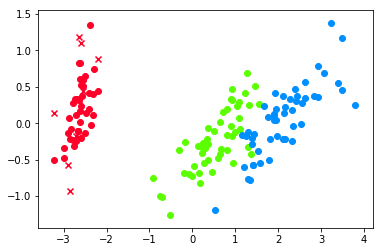

Algorithm :GaussianNB
% Error   :22.22222222222222
% Accuracy:77.77777777777777


In [45]:
analysis.visualise()
analysis.report()


Out of 45 test samples, 10 were mis-classified. This gives us a **success rate of 77.77%** and a **fail rate of 22.22%**

# Nasa dataset
## Data Loading and Pre-processing

In [46]:
dataset_nasa = Dataset("nasa")
dataset_nasa.log_level = Log.INFO
dataset_nasa.load_data()
dataset_nasa.prepare_data()

Loading: nasa


## Model training and testing

In [47]:
analysis_nasa = Analysis("GaussianNB", dataset_nasa)
analysis_nasa.log_level = Log.INFO
analysis_nasa.train()
analysis_nasa.test()

87.06467661691542

## Model graphing
Please note that the visualisation takes a few seconds to display.

/home/michel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/michel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:224: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


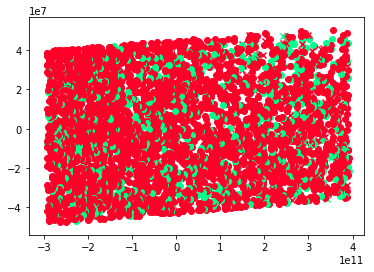

Algorithm :GaussianNB
% Error   :12.935323383084576
% Accuracy:87.06467661691542


In [48]:
analysis_nasa.visualise()
analysis_nasa.report()

# TODO list
  * Strech the data before training to see if it improves the output from the algorittm
  * Provide a different visualisation as the scatter is not informative for large datasets like "nasa"
